In [1]:
# Функция для отображения картинок
from IPython.display import Markdown

def embed_image(filepath):
    import base64
    with open(filepath, "rb") as img_file:
        b64_string = base64.b64encode(img_file.read()).decode("utf-8")
        md_code = f"![Embedded Image](data:image/png;base64,{b64_string})"
        return Markdown(md_code)

# Домашнее задание №2
В данном задании предлагается решить [контест](https://www.kaggle.com/competitions/vk-edu-bmstu-asr-competition/overview) на платформе Kaggle.
Основная цель данного задания состоит в том, чтобы студенты ознакомились с зоопарком открытых моделей для решения задачи распознавания речи, а так же попрактиковались в подходах по постпроцессингу распознанных гипотез для улучшения качества ASR.

Разрешается пользоваться всеми предобученными моделями.

**Строго запрещено размечать данные вручную!**

## Загрузка данных и инициализация модели

Для базового решения задания воспользуемся предобученной моделью Whisper от OpenAI. Для этого обратимся к платформе [HuggingFace](https://huggingface.co/collections/openai/whisper-release-6501bba2cf999715fd953013)

In [4]:
import os
import soundfile as sf
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import string
import pickle


In [2]:
# загрузим модель
from transformers import WhisperProcessor, WhisperForConditionalGeneration

device = "cuda:0"
model_name = "openai/whisper-base"
processor = WhisperProcessor.from_pretrained(model_name)
processor.feature_extractor.return_attention_mask = True
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

## Baseline подход к инференсу модели

In [4]:
def batch_inference(model, processor, path_to_wavs, batch_size, sampling_rate=16000):
    results = {}
    wav_files = os.listdir(path_to_wavs)

    forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe") # generates task specific special tokens

    for i in tqdm(range(0, len(wav_files), batch_size), total=np.ceil(len(wav_files) / batch_size)):
        audio_paths = wav_files[i : i + batch_size]

        batch = []

        for path in audio_paths:
            audio, _ = sf.read(os.path.join(path_to_wavs, path))
            batch.append(audio)
        inputs = processor(batch, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

        x, x_masks = inputs["input_features"].to(device), inputs["attention_mask"].to(device)

        with torch.no_grad():
            model.eval()
            output_ids = model.generate(x, forced_decoder_ids=forced_decoder_ids, attention_mask=x_masks)

        transcribtion = processor.batch_decode(output_ids, skip_special_tokens=True)

        results.update(zip(audio_paths, transcribtion))
    return results

In [3]:
path_to_wavs = "kaggle/wav"
batch_size = 64

In [15]:
results = batch_inference(model=model, processor=processor, path_to_wavs=path_to_wavs, batch_size=batch_size)

100%|██████████| 11/11.0 [01:01<00:00,  5.58s/it]


In [16]:
results

{'audio_0.wav': ' ТРЕВОЖНАЯ МУЗЫКА',
 'audio_1.wav': ' СМЕХ',
 'audio_10.wav': ' Пока не закончишь четверть. Без трое!',
 'audio_100.wav': ' ВЕСЕЛАЯ МУЗЫКА',
 'audio_101.wav': ' Захарченька Ксинья, 22 года Краснодарский край',
 'audio_102.wav': ' ПОЛИЦЕЙСКАЯ МУЗЫКА',
 'audio_103.wav': ' ПОЛИЦЕЙСКАЯ МУЗЫКА',
 'audio_104.wav': ' Скажьевич Александра 18 лет. Тюмейн.',
 'audio_105.wav': ' Карибова Камилла 22 года Нижний Камско',
 'audio_106.wav': ' Антонова Анастасия, 23 года Республика Мария Л',
 'audio_107.wav': ' Погрел',
 'audio_108.wav': ' Здравствуйте. Здравствуйте. Ну что?',
 'audio_109.wav': ' Вы готовы ксянс? Да, готов, что надо делать, давай.',
 'audio_11.wav': ' Отлично выгодишь, у Чери Миссия. Поздравляю!',
 'audio_110.wav': ' Говорите слово. В общем, у меня девушка и... Вижу, вижу.',
 'audio_111.wav': ' Ох, огненная девка! А, ну давайте посмотрим, что там за принцесса у моего принца, кто она?',
 'audio_112.wav': ' Императрицам. Её изовут Ехатерина. Но это шикарная, красивая и 

## Sample submission
Подготовим пример для загрузки на платформу

In [6]:
def dummy_postprocessing(data):
    for filename, hypo in data.items():
        hypo = hypo.strip()
        hypo = hypo.translate(str.maketrans('', '', string.punctuation))
        hypo = hypo.lower()
        data[filename] = hypo
    return data

In [7]:
clean_data = dummy_postprocessing(results)

In [8]:
sample_submission = pd.read_csv("kaggle/sample_submission.csv")

In [9]:
sample_submission.head(20)

,filename
0,audio_0.wav
1,audio_1.wav
2,audio_2.wav
3,audio_3.wav
4,audio_4.wav
5,audio_5.wav
6,audio_6.wav
7,audio_7.wav
8,audio_8.wav
9,audio_9.wav


In [10]:
sample_submission["hypo"] = sample_submission["filename"].apply(lambda x: clean_data[x])

In [11]:
sample_submission.insert(0, "id", sample_submission.index)

In [12]:
sample_submission.head()

,id,filename,hypo
0,0,audio_0.wav,тревожная музыка
1,1,audio_1.wav,смех
2,2,audio_2.wav,батиша жрел ракта грямли сюда иди я сказал
3,3,audio_3.wav,высоль не понял
4,4,audio_4.wav,быстро за мной


In [13]:
sample_submission.to_csv("baseline.csv", index=False)

## Идеи по улучшению предсказаний:
* Всегда ли LAS архитектура работает на тишине корректно?
* Как насчет нормализации текста? (19.02 - девятнадцатое февраля, 20 лет - двадцать лет)
* Может быть попробовать рескоринг? (возвращаем больше, чем топ-1 гипотезу из бима)
* Может быть взять модель побольше?
## Соревнование доступно по [ссылке](https://www.kaggle.com/t/325b553468db4d01a583e29624a7685d)

# Решение задачи

### В качестве первого теста возьму свою кастомную версию Whisper-small, которую я когда-то дообучил на Common Voice.  
Она лежит в открытом доступе на моём Hugging Face и её можно найти по [ссылке](https://huggingface.co/Dok-tor/whisper-small-ru)

Проделаю то же самое, что и в примере

In [2]:
# загрузим модель
from transformers import WhisperProcessor, WhisperForConditionalGeneration

device = "cuda:0"
model_name = "Dok-tor/whisper-small-ru"
processor = WhisperProcessor.from_pretrained(model_name)
processor.feature_extractor.return_attention_mask = True
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

In [3]:
path_to_wavs = "kaggle/wav"
batch_size = 2

In [4]:
def batch_inference_1(model, processor, path_to_wavs, batch_size, sampling_rate=16000):
    results = {}
    wav_files = os.listdir(path_to_wavs)

    forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe") # generates task specific special tokens

    for i in tqdm(range(0, len(wav_files), batch_size), total=np.ceil(len(wav_files) / batch_size)):
        audio_paths = wav_files[i : i + batch_size]

        batch = []

        for path in audio_paths:
            audio, _ = sf.read(os.path.join(path_to_wavs, path))
            batch.append(audio)
        inputs = processor(batch, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

        x, x_masks = inputs["input_features"].to(device), inputs["attention_mask"].to(device)

        with torch.no_grad():
            model.eval()
            output_ids = model.generate(x, attention_mask=x_masks)

        transcribtion = processor.batch_decode(output_ids, skip_special_tokens=True)

        results.update(zip(audio_paths, transcribtion))
    return results

In [7]:
results = batch_inference_1(model=model, processor=processor, path_to_wavs=path_to_wavs, batch_size=batch_size)

  0%|          | 0/321.0 [00:00<?, ?it/s]You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
C:\Users\zacgr\Documents\GitReps\technopark\NN\.venv_nn\Lib\site-packages\transformers\models\whisper\modeling_whisper.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 321/321.0 [15:41<00:00,  2.93s/it] 


In [8]:
results

{'audio_0.wav': ' ТРЕВОЖНАЯ МУЗЫКА',
 'audio_1.wav': 'Ого!',
 'audio_10.wav': 'Пока не закончишь четверть, без трое!',
 'audio_100.wav': ' А',
 'audio_101.wav': 'Захарчин Качсинья, двадцать два года, Краснодарский край.',
 'audio_102.wav': 'Доставка',
 'audio_103.wav': ' Добро пожаловать на наш канал!',
 'audio_104.wav': 'Сташ Кевич Александра, восемнадцать лет. Тюмень!',
 'audio_105.wav': 'Карибова-Камилла, двадцать два года, Нижникамск.',
 'audio_106.wav': 'Антонова Анастасия, двадцать три года Республика Мариэлл.',
 'audio_107.wav': 'Автор',
 'audio_108.wav': 'Здравствуйте. – Здравствуйте? Ну что?',
 'audio_109.wav': 'Вы готовы к сеансу? Да, готов, что надо делать, давайте.',
 'audio_11.wav': 'Отлично выглядишь! У тебя ремиссия? Поздравляю!',
 'audio_110.wav': 'Говорите слово просто. В общем у меня девушка и... Вижу, вижу...',
 'audio_111.wav': 'Ох, огненная девка! Ну давайте посмотрим, что там за принцессу моего принца, кто она?',
 'audio_112.wav': 'Императрица… ее и зовут Екатерин

In [9]:
def dummy_postprocessing(data):
    for filename, hypo in data.items():
        hypo = hypo.strip()
        hypo = hypo.translate(str.maketrans('', '', string.punctuation))
        hypo = hypo.lower()
        data[filename] = hypo
    return data

In [10]:
clean_data = dummy_postprocessing(results)

In [11]:
sample_submission = pd.read_csv("kaggle/sample_submission.csv")

In [13]:
sample_submission["hypo"] = sample_submission["filename"].apply(lambda x: clean_data[x])

In [14]:
sample_submission.insert(0, "id", sample_submission.index)

In [15]:
sample_submission.to_csv("1_my_whisp_small.csv", index=False)

### Получилось, надо сказать, так себе, скорее всего дело в том, что Common Voice имеет другую специфику

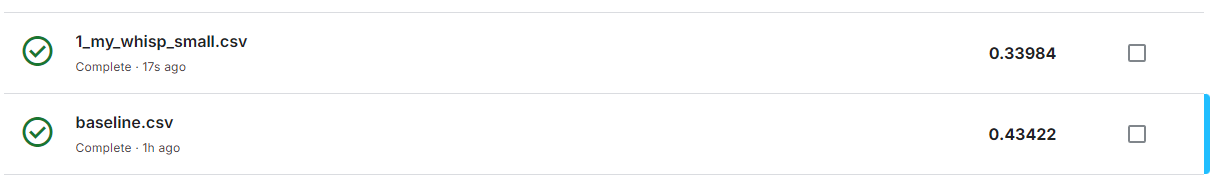

In [17]:
display(embed_image("pictures/1.png"))

In [18]:
# загрузим модель
from transformers import WhisperProcessor, WhisperForConditionalGeneration

device = "cuda:0"
model_name = "openai/whisper-large-v3-turbo"
processor = WhisperProcessor.from_pretrained(model_name)
processor.feature_extractor.return_attention_mask = True
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

In [19]:
path_to_wavs = "kaggle/wav"
batch_size = 1

In [25]:
def batch_inference_2(model, processor, path_to_wavs, batch_size, sampling_rate=16000):
    import os
    import numpy as np
    import soundfile as sf
    from tqdm import tqdm
    import torch

    results = {}
    wav_files = os.listdir(path_to_wavs)

    forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")  # Генерирует специальные токены для задачи

    for i in tqdm(range(0, len(wav_files), batch_size), total=np.ceil(len(wav_files) / batch_size)):
        audio_paths = wav_files[i : i + batch_size]

        batch = []

        for path in audio_paths:
            audio, _ = sf.read(os.path.join(path_to_wavs, path))
            # Дополняем или обрезаем аудио до 30 секунд
            max_audio_length = sampling_rate * 30  # 30 секунд аудио
            if len(audio) < max_audio_length:
                pad_length = max_audio_length - len(audio)
                audio = np.pad(audio, (0, pad_length), mode='constant', constant_values=0)
            else:
                audio = audio[:max_audio_length]
            batch.append(audio)

        inputs = processor(
            batch,
            sampling_rate=sampling_rate,
            return_tensors="pt",
            padding=False  # Аудио уже имеет нужную длину
        )

        x = inputs["input_features"].to(device)

        with torch.no_grad():
            model.eval()
            output_ids = model.generate(
                x,
                forced_decoder_ids=forced_decoder_ids  # Указываем языковые токены
            )

        transcriptions = processor.batch_decode(output_ids, skip_special_tokens=True)

        results.update(zip(audio_paths, transcriptions))
    return results


In [26]:
results = batch_inference_2(model=model, processor=processor, path_to_wavs=path_to_wavs, batch_size=batch_size)

  0%|          | 0/642.0 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
100%|██████████| 642/642.0 [30:48<00:00,  2.88s/it]


In [27]:
results

{'audio_0.wav': ' Субтитры создавал DimaTorzok',
 'audio_1.wav': ' Субтитры сделал DimaTorzok',
 'audio_10.wav': ' пока не закончишь четверть. Без троек!',
 'audio_100.wav': ' Субтитры подогнал «Симон»!',
 'audio_101.wav': ' Захарченко Ксения, 22 года, Крестнодарский край.',
 'audio_102.wav': ' Субтитры сделал DimaTorzok',
 'audio_103.wav': ' ДИНАМИЧНАЯ МУЗЫКА',
 'audio_104.wav': ' Старкевич Александра, 18 лет. Тюмень.',
 'audio_105.wav': ' Гарипова Камилла, 22 года, Нижнекамск.',
 'audio_106.wav': ' Антонова Анастасия, 23 года, Республика Мариэлл.',
 'audio_107.wav': ' Продолжение следует...',
 'audio_108.wav': ' Здравствуйте. Здравствуйте. Ну что...',
 'audio_109.wav': ' Вы готовы к сеансу? Да, готов. Что надо делать? Давайте.',
 'audio_11.wav': ' Отлично выглядишь! У тебя ремиссия? Поздравляю!',
 'audio_110.wav': ' Поговорите свой вопрос. В общем, у меня девушка и... Вижу, вижу.',
 'audio_111.wav': ' Ох, огненная девка, а! Ну давайте посмотрим, что там за принцесса у моего принца, к

In [33]:
# сохраним результаты "от греха"

with open('results_whisper_largev3-turbo.pkl', 'wb') as file:
    pickle.dump(results, file)

In [5]:
with open('results_whisper_largev3-turbo.pkl', 'rb') as file:  # 'rb' означает чтение в бинарном режиме
    results = pickle.load(file)

In [6]:
results

{'audio_0.wav': ' Субтитры создавал DimaTorzok',
 'audio_1.wav': ' Субтитры сделал DimaTorzok',
 'audio_10.wav': ' пока не закончишь четверть. Без троек!',
 'audio_100.wav': ' Субтитры подогнал «Симон»!',
 'audio_101.wav': ' Захарченко Ксения, 22 года, Крестнодарский край.',
 'audio_102.wav': ' Субтитры сделал DimaTorzok',
 'audio_103.wav': ' ДИНАМИЧНАЯ МУЗЫКА',
 'audio_104.wav': ' Старкевич Александра, 18 лет. Тюмень.',
 'audio_105.wav': ' Гарипова Камилла, 22 года, Нижнекамск.',
 'audio_106.wav': ' Антонова Анастасия, 23 года, Республика Мариэлл.',
 'audio_107.wav': ' Продолжение следует...',
 'audio_108.wav': ' Здравствуйте. Здравствуйте. Ну что...',
 'audio_109.wav': ' Вы готовы к сеансу? Да, готов. Что надо делать? Давайте.',
 'audio_11.wav': ' Отлично выглядишь! У тебя ремиссия? Поздравляю!',
 'audio_110.wav': ' Поговорите свой вопрос. В общем, у меня девушка и... Вижу, вижу.',
 'audio_111.wav': ' Ох, огненная девка, а! Ну давайте посмотрим, что там за принцесса у моего принца, к

## Модель действительно очень умная, однако некоторые предсказания выглядят как "выстрел в ногу" с точки зрения предполагаемой Ground Truth.  
Например:  
   
**' Продолжение следует...'**  - Модель очевидно знает об этом аудио больше чем я (скорее всего было в обучающей выборке)  
**' Субтитры сделал DimaTorzok'** - Аналогичная история  
**' Все это о телевизорах LG OLED и его.'**  - Здесь спорный момент: есть ли в Ground Truth латинские символы или правильный вариант 'ЛДЖИ ОЛЕД'  
**' Лисовская! АПЛОДИСМЕНТЫ Здравствуйте, дорогие девочки! Я обещаю...'** - Здесь вообще определение фона 'Аплодисменты'  
**' ДИНАМИЧНАЯ МУЗЫКА'** - Нет речи


У проблемы ' Продолжение следует...', ' Субтитры сделал DimaTorzok' и ' ДИНАМИЧНАЯ МУЗЫКА' есть 2 решения: интересное и простое.  
Интересное - это использовать дополнительную модель для определения наличия/отсутствия речи на записи.  
Простое - отфильтровать полученные предсказания по ключевым словам.  
Для начала попробуем простое.

In [147]:
def custom_postprocessing(data):
    for filename, hypo in data.items():
        hypo = hypo.strip()
        hypo = hypo.translate(str.maketrans('', '', string.punctuation))
        hypo = hypo.lower()

        # Убираем кавычки
        hypo = hypo.replace('"', '').replace("'", "").replace("«", "").replace("»", "")
        
        # Убираем слово "аплодисменты"
        hypo = hypo.replace('аплодисменты', '')

        # Проверяем наличие конструкций, которые сигнализируют, что запись не содержит звук
        if 'субтитры' in hypo or 'продолжение следует' in hypo or 'динамичная музыка' in hypo:
            hypo = ""

        if hypo == "":
            hypo = "\"\""

        data[filename] = hypo
    return data

In [148]:
clean_data = custom_postprocessing(results)

In [149]:
clean_data

{'audio_0.wav': '""',
 'audio_1.wav': '""',
 'audio_10.wav': 'пока не закончишь четверть без троек',
 'audio_100.wav': '""',
 'audio_101.wav': 'захарченко ксения 22 года крестнодарский край',
 'audio_102.wav': '""',
 'audio_103.wav': '""',
 'audio_104.wav': 'старкевич александра 18 лет тюмень',
 'audio_105.wav': 'гарипова камилла 22 года нижнекамск',
 'audio_106.wav': 'антонова анастасия 23 года республика мариэлл',
 'audio_107.wav': '""',
 'audio_108.wav': 'здравствуйте здравствуйте ну что',
 'audio_109.wav': 'вы готовы к сеансу да готов что надо делать давайте',
 'audio_11.wav': 'отлично выглядишь у тебя ремиссия поздравляю',
 'audio_110.wav': 'поговорите свой вопрос в общем у меня девушка и вижу вижу',
 'audio_111.wav': 'ох огненная девка а ну давайте посмотрим что там за принцесса у моего принца кто она кто она',
 'audio_112.wav': 'императрица ее и зовут екатерина ну это шикарная красивая изобильная ресурсная женщина',
 'audio_113.wav': 'что тебя в ней не устраивает а есть мне кто 

In [140]:
sample_submission = pd.read_csv("kaggle/sample_submission.csv")

In [141]:
sample_submission["hypo"] = sample_submission["filename"].apply(lambda x: clean_data[x])

In [142]:
sample_submission.insert(0, "id", sample_submission.index)

In [143]:
sample_submission.to_csv("2_whisp_largev3_post_proc.csv", index=False)

#### Как показала практика, не важно - удаляю я "пустые" аудиозаписи или нет, WER остаётся одинаковым:

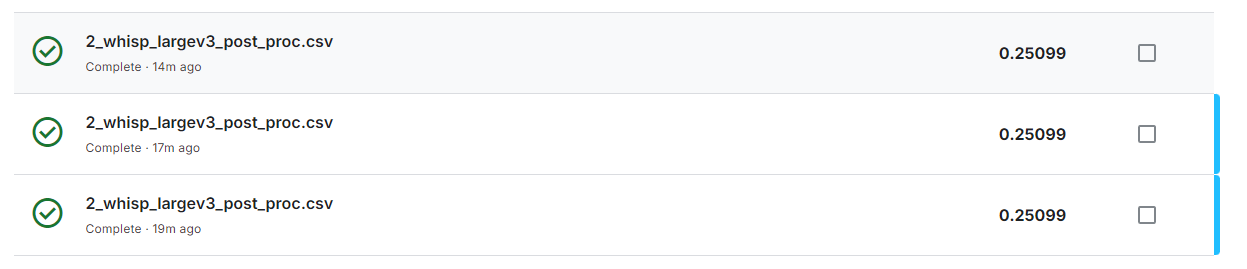

In [144]:
display(embed_image("pictures/2.png"))

Гипотеза: метрика на соревновании берётся максимальная, а не средняя или суммарная. Иначе несколько строчек с огромной разницей повлияли бы на ситуацию.

### Попробуем преобразовать числа строчной вид

In [156]:
import re
from num2words import num2words

def replace_numbers_with_text(text):
    # Находим все числа в тексте
    numbers = re.findall(r'\d+', text)
    
    for number in numbers:
        # Переводим число в текст
        number_text = num2words(int(number), lang='ru')
        # Заменяем число на текст
        text = text.replace(number, number_text)
    
    return text

In [157]:
def custom_postprocessing_2(data):
    for filename, hypo in data.items():
        hypo = hypo.strip()
        hypo = hypo.translate(str.maketrans('', '', string.punctuation))
        hypo = hypo.lower()

        # Убираем кавычки
        hypo = hypo.replace('"', '').replace("'", "").replace("«", "").replace("»", "")
        
        # Убираем слово "аплодисменты"
        hypo = hypo.replace('аплодисменты', '')
        

        # Проверяем наличие конструкций, которые сигнализируют, что запись не содержит звук
        if 'субтитры' in hypo or 'продолжение следует' in hypo or 'динамичная музыка' in hypo:
            hypo = ""
            
        hypo = replace_numbers_with_text(hypo)

        if hypo == "":
            hypo = "\"\""

        data[filename] = hypo
    return data

In [158]:
with open('results_whisper_largev3-turbo.pkl', 'rb') as file:  # 'rb' означает чтение в бинарном режиме
    results = pickle.load(file)

In [159]:
clean_data = custom_postprocessing_2(results)

In [160]:
clean_data

{'audio_0.wav': '""',
 'audio_1.wav': '""',
 'audio_10.wav': 'пока не закончишь четверть без троек',
 'audio_100.wav': '""',
 'audio_101.wav': 'захарченко ксения двадцать два года крестнодарский край',
 'audio_102.wav': '""',
 'audio_103.wav': '""',
 'audio_104.wav': 'старкевич александра восемнадцать лет тюмень',
 'audio_105.wav': 'гарипова камилла двадцать два года нижнекамск',
 'audio_106.wav': 'антонова анастасия двадцать три года республика мариэлл',
 'audio_107.wav': '""',
 'audio_108.wav': 'здравствуйте здравствуйте ну что',
 'audio_109.wav': 'вы готовы к сеансу да готов что надо делать давайте',
 'audio_11.wav': 'отлично выглядишь у тебя ремиссия поздравляю',
 'audio_110.wav': 'поговорите свой вопрос в общем у меня девушка и вижу вижу',
 'audio_111.wav': 'ох огненная девка а ну давайте посмотрим что там за принцесса у моего принца кто она кто она',
 'audio_112.wav': 'императрица ее и зовут екатерина ну это шикарная красивая изобильная ресурсная женщина',
 'audio_113.wav': 'что 

In [161]:
sample_submission = pd.read_csv("kaggle/sample_submission.csv")
sample_submission["hypo"] = sample_submission["filename"].apply(lambda x: clean_data[x])
sample_submission.insert(0, "id", sample_submission.index)
sample_submission.to_csv("3_whisp_largev3_text_digits.csv", index=False)

### Результат лучше

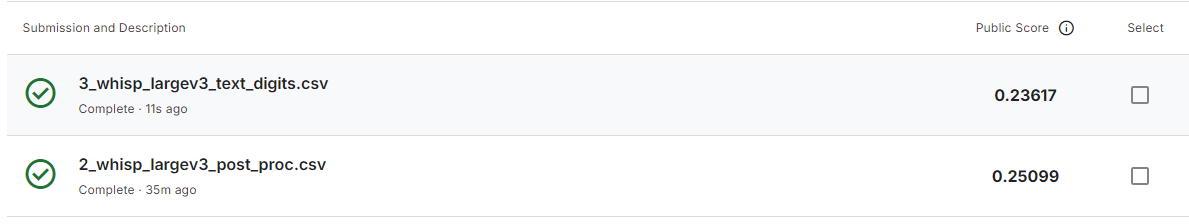

In [162]:
display(embed_image("pictures/3.png"))

## Выводы:  
Я думаю, что постобработка текстов с помощью обычных алгоритмов может дать очень существенное преимущество, особенно это касается скорости преобразования, по сравнению со случаем, когда используются наоборот алгоритмы ML ещё на этапе предобработки звука, посколько Whisper и так может распознавать с достаточной точностью